In [9]:
#Manipulation Packages
import pandas as pd
import numpy as np
from datetime import datetime
import re
#EDA Visualization Packages
import seaborn as sns
import matplotlib.pyplot as plt
#Interactive Visualization Packages
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
#Dashboards Packages
from dash import Dash , html , dcc ,dash_table
from jupyter_dash import JupyterDash
from dash.dependencies import Input , Output
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
from dash.exceptions import PreventUpdate
import dash_mantine_components as dmc

- __Discovering__

In [10]:
df = pd.read_json('Glassdoor.json')
df.head()

,Job_Title,Company_Title,Location,Date_Posted,Size,Founded,Type,Industry,Sector,Revenue,Average_Salary,Estimate_Salary,Job_Description
0,Entry Level Business Analyst,BACloudSystems,Remote,2023-08-12,unknown,NaN,company - public,health care services & hospitals,healthcare,unknown / non-applicable,"$58,445 /yr (est.)\n$50K \n$68K",$50K to $68K,Our Organization:\n\nWelcome to Arkos Health! ...
1,Entry Level Business Analyst,CapitalPlanHoldings,Remote,2023-08-12,10000+ employees,1927.0,government,national agencies,government & public administration,unknown / non-applicable,"$128,816 /yr (est.)\n$112K \n$146K",$112K to $146K,Duties\n\nJoining Customs & Border Protection ...
2,Data Analyst,Arch Systems LLC,"Baltimore, MD",2023-08-12,1001 to 5000 employees,1971.0,company - public,enterprise software & network solutions,information technology,$100 to $500 million (usd),"$85,500 /yr (est.)\n$71K \n$103K",$71K to $103K,Technical Business Analyst\n\nHansen Technolog...
3,Data Analyst,KesarWeb,"Fresno, CA",2023-08-12,1001 to 5000 employees,1981.0,company - private,banking & lending,financial services,unknown / non-applicable,"$95,000 /yr (est.)\n$83K \n$107K",$83K to $107K,THE OPPORTUNITY:\n\nWe are seeking a talented ...
4,Data Analyst II,Xplor,"Saint Louis, MO",2023-08-13,10000+ employees,1955.0,company - public,insurance carriers,insurance,$10+ billion (usd),"$86,000 /yr (est.)\n$51K \n$121K",$51K to $121K,"Salary Range: $51,000 - $121,000\n\n\nWe’ve Go..."


In [11]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Job_Title        90 non-null     object 
 1   Company_Title    90 non-null     object 
 2   Location         90 non-null     object 
 3   Date_Posted      90 non-null     object 
 4   Size             81 non-null     object 
 5   Founded          68 non-null     float64
 6   Type             81 non-null     object 
 7   Industry         72 non-null     object 
 8   Sector           72 non-null     object 
 9   Revenue          81 non-null     object 
 10  Average_Salary   69 non-null     object 
 11  Estimate_Salary  69 non-null     object 
 12  Job_Description  90 non-null     object 
dtypes: float64(1), object(12)
memory usage: 878.7 KB


- __Cleaning__

In [12]:
pd.DataFrame(df.isna().sum(),columns=['# missing'])

,# missing
Job_Title,0
Company_Title,0
Location,0
Date_Posted,0
Size,9
Founded,22
Type,9
Industry,18
Sector,18
Revenue,9


<AxesSubplot:>

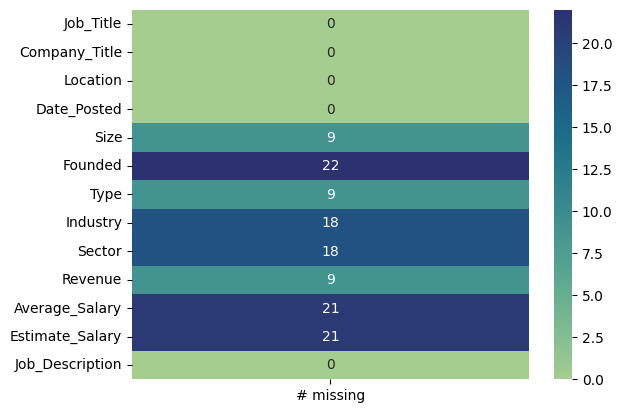

In [13]:
sns.heatmap(pd.DataFrame(df.isna().sum(),columns=['# missing']) , annot= True , fmt='d',cmap="crest")

In [14]:
#Filling Null Values
df = df.fillna({'Founded':0 , 'Size':'unknown','Type':'unspecified','Sector':'unspecified','Industry':'unspecified','Revenue':'unknown','Average_Salary':'unknown','Estimate_Salary':'unknown'})
if any(df.isna().sum()) > 1 :
    print('UnClean')
else:
    print('All Data are Clean')    

All Data are Clean


In [15]:
# Convert Data Types
df.dtypes

Job_Title           object
Company_Title       object
Location            object
Date_Posted         object
Size                object
Founded            float64
Type                object
Industry            object
Sector              object
Revenue             object
Average_Salary      object
Estimate_Salary     object
Job_Description     object
dtype: object

In [16]:
# Explore the variables that could convert it into category type but first we must check the number of unique  is less than the number of rows divided by two, otherwise, it will increase memory usage instead decrease it
for col in df.columns:
    if df[col].nunique() < (len(df) / 2):
        print(col , '🟢Valid')
    else:
        print(col , '🔻Invalide')    

Job_Title 🟢Valid
Company_Title 🔻Invalide
Location 🟢Valid
Date_Posted 🟢Valid
Size 🟢Valid
Founded 🟢Valid
Type 🟢Valid
Industry 🟢Valid
Sector 🟢Valid
Revenue 🟢Valid
Average_Salary 🟢Valid
Estimate_Salary 🟢Valid
Job_Description 🟢Valid


In [17]:
# Convert these variables to category type
for col in ['Job_Title','Company_Title','Location','Type','Industry','Sector']:
    df[col] = df[col].astype('category')

In [18]:
# Convert these columns to date type and string and intager
df = df.astype({'Date_Posted':'datetime64[ns]','Job_Description':'string','Founded':'int'})

In [19]:
# Check duplication
def Row_duplication(df):
    '''
    This function takes the data and iterates for each other rows 
    to make sure that row hasn't duplicated with another one 
    if there are two duplicate rows we will store their indexes
    '''
    duplicates_index = []
    for i in range(len(df)):
        main_comp = df.iloc[i].tolist()#hold first row
        for ii in range(len(df)):
            if i == ii:
                ii += 1
            try:    
                second_comp = df.iloc[ii].tolist()#hold the others rows
            except IndexError: # because the last index will have no more to add so I have to break the loop to prevent the index error
                break    
            check_length = [m for m , s in zip(main_comp , second_comp) if m == s] # store any of them if they are equal to each other
            if len(check_length) == df.shape[1]:# if the length of the row is equal to the original row that means all row is equal
                duplicates_index.append((i , ii))
    return duplicates_index
indexes = Row_duplication(df)
indexes

[(8, 38),
 (8, 67),
 (30, 60),
 (31, 61),
 (32, 62),
 (33, 63),
 (34, 64),
 (35, 65),
 (36, 66),
 (38, 8),
 (38, 67),
 (39, 68),
 (40, 69),
 (41, 70),
 (42, 71),
 (43, 73),
 (44, 72),
 (45, 76),
 (46, 74),
 (47, 77),
 (49, 75),
 (50, 78),
 (51, 81),
 (52, 83),
 (53, 85),
 (54, 86),
 (55, 80),
 (56, 79),
 (57, 84),
 (60, 30),
 (61, 31),
 (62, 32),
 (63, 33),
 (64, 34),
 (65, 35),
 (66, 36),
 (67, 8),
 (67, 38),
 (68, 39),
 (69, 40),
 (70, 41),
 (71, 42),
 (72, 44),
 (73, 43),
 (74, 46),
 (75, 49),
 (76, 45),
 (77, 47),
 (78, 50),
 (79, 56),
 (80, 55),
 (81, 51),
 (83, 52),
 (84, 57),
 (85, 53),
 (86, 54)]

In [20]:
# Let's validate our results
from random import choice
idx = choice(indexes)
print(df.iloc[idx[0]])
print('==' * 50)
print(df.loc[idx[1]])


Job_Title                                               Data Analyst
Company_Title                                              WidePoint
Location                                                      Remote
Date_Posted                                      2023-08-12 00:00:00
Size                                            201 to 500 employees
Founded                                                         1997
Type                                                company - public
Industry                     information technology support services
Sector                                        information technology
Revenue                                    $25 to $100 million (usd)
Average_Salary                       $80,000 /yr (est.)\n$75K \n$85K
Estimate_Salary                                        $75K  to $85K
Job_Description    Data Analyst- WidePoint Integrated Solutions C...
Name: 77, dtype: object
Job_Title                                               Data Analyst
Company_Ti

In [21]:
# That's normal because a lot of companies publish the same position, salary, and all same requirements every time want to hire someone
len(indexes)

56

In [22]:
# Fix some columns
df = df.assign(
    # Remove (Remote) and - Remote from our title
    Job_Title = df.Job_Title.astype('str').apply(lambda x : re.split(r'[-()]+\s?.+', x)[0]),

    # Fix the characters of the company title 
    Company_Title = df.Company_Title.str.title() , 

    # Remove the company word from the column to be only puplic or private
    Type = df.Type.str.split('-').str[-1]
              )
df.head()  

,Job_Title,Company_Title,Location,Date_Posted,Size,Founded,Type,Industry,Sector,Revenue,Average_Salary,Estimate_Salary,Job_Description
0,Entry Level Business Analyst,Bacloudsystems,Remote,2023-08-12,unknown,0,public,health care services & hospitals,healthcare,unknown / non-applicable,"$58,445 /yr (est.)\n$50K \n$68K",$50K to $68K,Our Organization: Welcome to Arkos Health! We...
1,Entry Level Business Analyst,Capitalplanholdings,Remote,2023-08-12,10000+ employees,1927,government,national agencies,government & public administration,unknown / non-applicable,"$128,816 /yr (est.)\n$112K \n$146K",$112K to $146K,Duties Joining Customs & Border Protection wi...
2,Data Analyst,Arch Systems Llc,"Baltimore, MD",2023-08-12,1001 to 5000 employees,1971,public,enterprise software & network solutions,information technology,$100 to $500 million (usd),"$85,500 /yr (est.)\n$71K \n$103K",$71K to $103K,Technical Business Analyst Hansen Technologie...
3,Data Analyst,Kesarweb,"Fresno, CA",2023-08-12,1001 to 5000 employees,1981,private,banking & lending,financial services,unknown / non-applicable,"$95,000 /yr (est.)\n$83K \n$107K",$83K to $107K,THE OPPORTUNITY: We are seeking a talented Bu...
4,Data Analyst II,Xplor,"Saint Louis, MO",2023-08-13,10000+ employees,1955,public,insurance carriers,insurance,$10+ billion (usd),"$86,000 /yr (est.)\n$51K \n$121K",$51K to $121K,"Salary Range: $51,000 - $121,000 We’ve Got Y..."


- __Feature Engineering__

In [23]:
# Get only the name of the state
df['State_name'] = df.Location.str.split(',').str[0].str.split(' ').str[0]
df['State_name'].head()

0       Remote
1       Remote
2    Baltimore
3       Fresno
4        Saint
Name: State_name, dtype: object

In [24]:
# First add -01-01 to complete its date and  convert it to date type and if there's an error it returns its Null values 
# after that minus the date posted which is the recent date with the founded date which the old data and convert it to days and lastly fill null values with zero and convert it to integer
df['Days_Since_Founded'] = (df.Date_Posted - pd.to_datetime(df.Founded.astype('str').apply(lambda x : x+'-01'+'-01' if x != '0' else '0') , errors='coerce')).dt.days.fillna(0).astype('int')
df['Days_Since_Founded'].head()

0        0
1    35287
2    19216
3    15563
4    25061
Name: Days_Since_Founded, dtype: int32

In [25]:
def employess(x):
    '''
    First replace unknown values by 0
    Second, find all numbers that have "to" between them or haven't and check if length one means it has one character
    Third, find all numbers that have "to" between them or haven't and check if length two means it has two characters so I will take the average from it
    '''
    if  re.findall('unknown',x):
        x ='0'
    elif len(''.join(re.findall(r'\d+\s+to+\s+\d+|\d' ,x)).split('to')) == 1 :
        x = ''.join(re.findall(r'\d+\s+to+\s+\d+|\d' ,x)).split('to')[0]
    elif len(''.join(re.findall(r'\d+\s+to+\s+\d+|\d' ,x)).split('to')) == 2:
           x = int((int(''.join(re.findall(r'\d+\s+to+\s+\d+|\d' ,x)).split('to')[0]) + int(''.join(re.findall(r'\d+\s+to+\s+\d+|\d' ,x)).split('to')[1]) / 2))
    return x

df['Number_of_Employess'] = df.Size.apply(employess)
df.Number_of_Employess.head()

0        0
1    10000
2     3501
3     3501
4    10000
Name: Number_of_Employess, dtype: object

In [26]:
def revenue(x):
    '''
    this function takes every record of reveue column
    and convert it to numaricl column .
    First:If the Revenue is unknown return it 0
    Second:If the Revenue record has two numbers take the average from it and also if have a billion word multiply it by 1000000000 if not that means there is a million word so multiply it by 1000000
    Thirt : If the Revenue record has one number and also if has a billion word multiply it by 1000000000 if not that means there is a million word so multiply it by 1000000
    '''
    if  re.findall('unknown',x):
        x ='0'
    elif len(re.sub('[^\d]',' ',x).strip().split('    ')) != 1:
        x =  int(((int(re.sub('[^\d]',' ',x).strip().split(' ')[0]) + int(re.sub('[^\d]',' ',x).strip().split(' ')[-1]))/ 2) * 1000000000 ) if re.findall('billion' , x) else int((int(re.sub('[^\d]',' ',x).strip().split(' ')[0]) + int(re.sub('[^\d]',' ',x).strip().split(' ')[-1]) / 2 ) * 1000000)
    elif len(re.sub('[^\d]',' ',x).strip().split('    ')) == 1:
        x = int(int(''.join(re.findall('[\d]',x))) * 1000000000 ) if re.findall('billion' , x) else int(int(''.join(re.findall('[\d]',x))) * 1000000 ) 
    return x
    
df['Revenue_Numbers'] = df['Revenue'].apply(revenue).astype('int64')
df.Revenue_Numbers.head()

0              0
1              0
2      350000000
3              0
4    10000000000
Name: Revenue_Numbers, dtype: int64

In [27]:
# Replace \n by space and then split by / and select the last index and then split by space and select the first index which contains yr or hr and then grab only characters between A to z  and replace by Yearly and Hourly and lastly convert it to category type
df['Salary_payment'] = df['Average_Salary'].str.replace('\n','').str.split('/').str[-1].str.split(' ').str[0].apply(lambda x : re.sub(r'[^A-z]','',x)).map({'yr':'Yearly','hr':'Hourly','unknown':'Unknown'}).astype('category')
df.Salary_payment.value_counts()

Yearly     62
Unknown    21
Hourly      7
Name: Salary_payment, dtype: int64

In [28]:
# Find all number that has comma and space after it which is the number that I want to extract, and if exist return it if not return 0
df['Ave_Salary'] = df.Average_Salary.apply(lambda x : re.findall(r'[\d,]+\s' , x)[0].replace(',','') if re.findall(r'[\d,]+\s' , x) else 0).astype('int')
df['Ave_Salary'].head()

0     58445
1    128816
2     85500
3     95000
4     86000
Name: Ave_Salary, dtype: int32

- __EDA__

In [29]:
#Describe Numerical data 
df.describe().round()

,Founded,Days_Since_Founded,Revenue_Numbers,Ave_Salary
count,90.0,90.0,9.000000e+01,90.0
mean,1490.0,14129.0,1.556639e+09,59309.0
std,853.0,16103.0,3.208489e+09,42724.0
min,0.0,0.0,0.000000e+00,0.0
25%,1847.0,588.0,0.000000e+00,0.0
50%,1958.0,8625.0,0.000000e+00,77500.0
75%,2000.0,24512.0,3.500000e+08,89375.0
max,2022.0,64507.0,1.000000e+10,128816.0


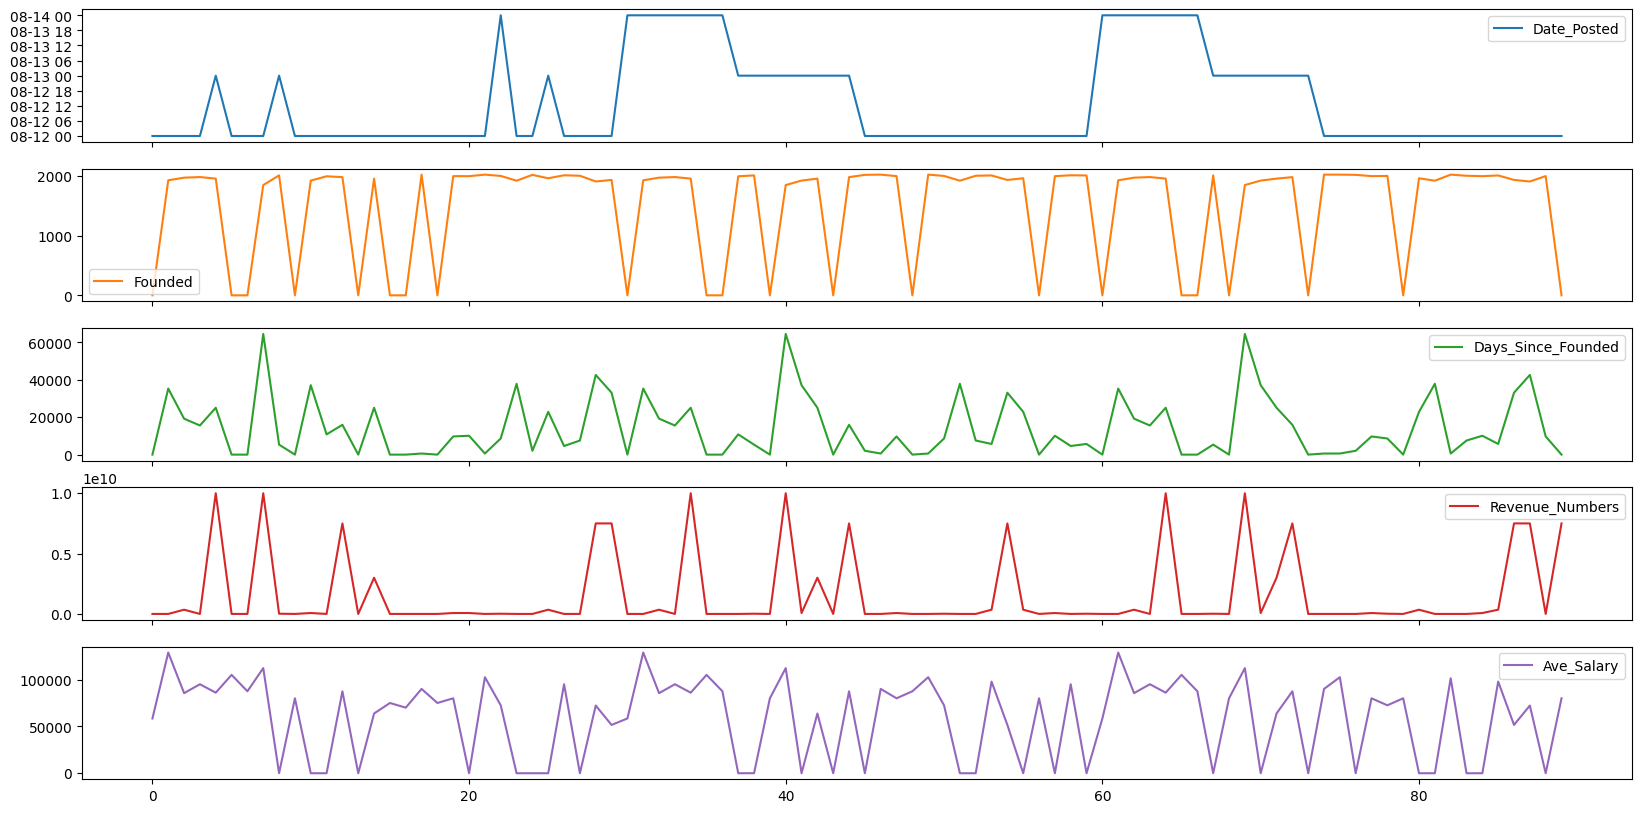

In [30]:
df.plot(subplots=True ,layout=(5,1),figsize=(20,10));

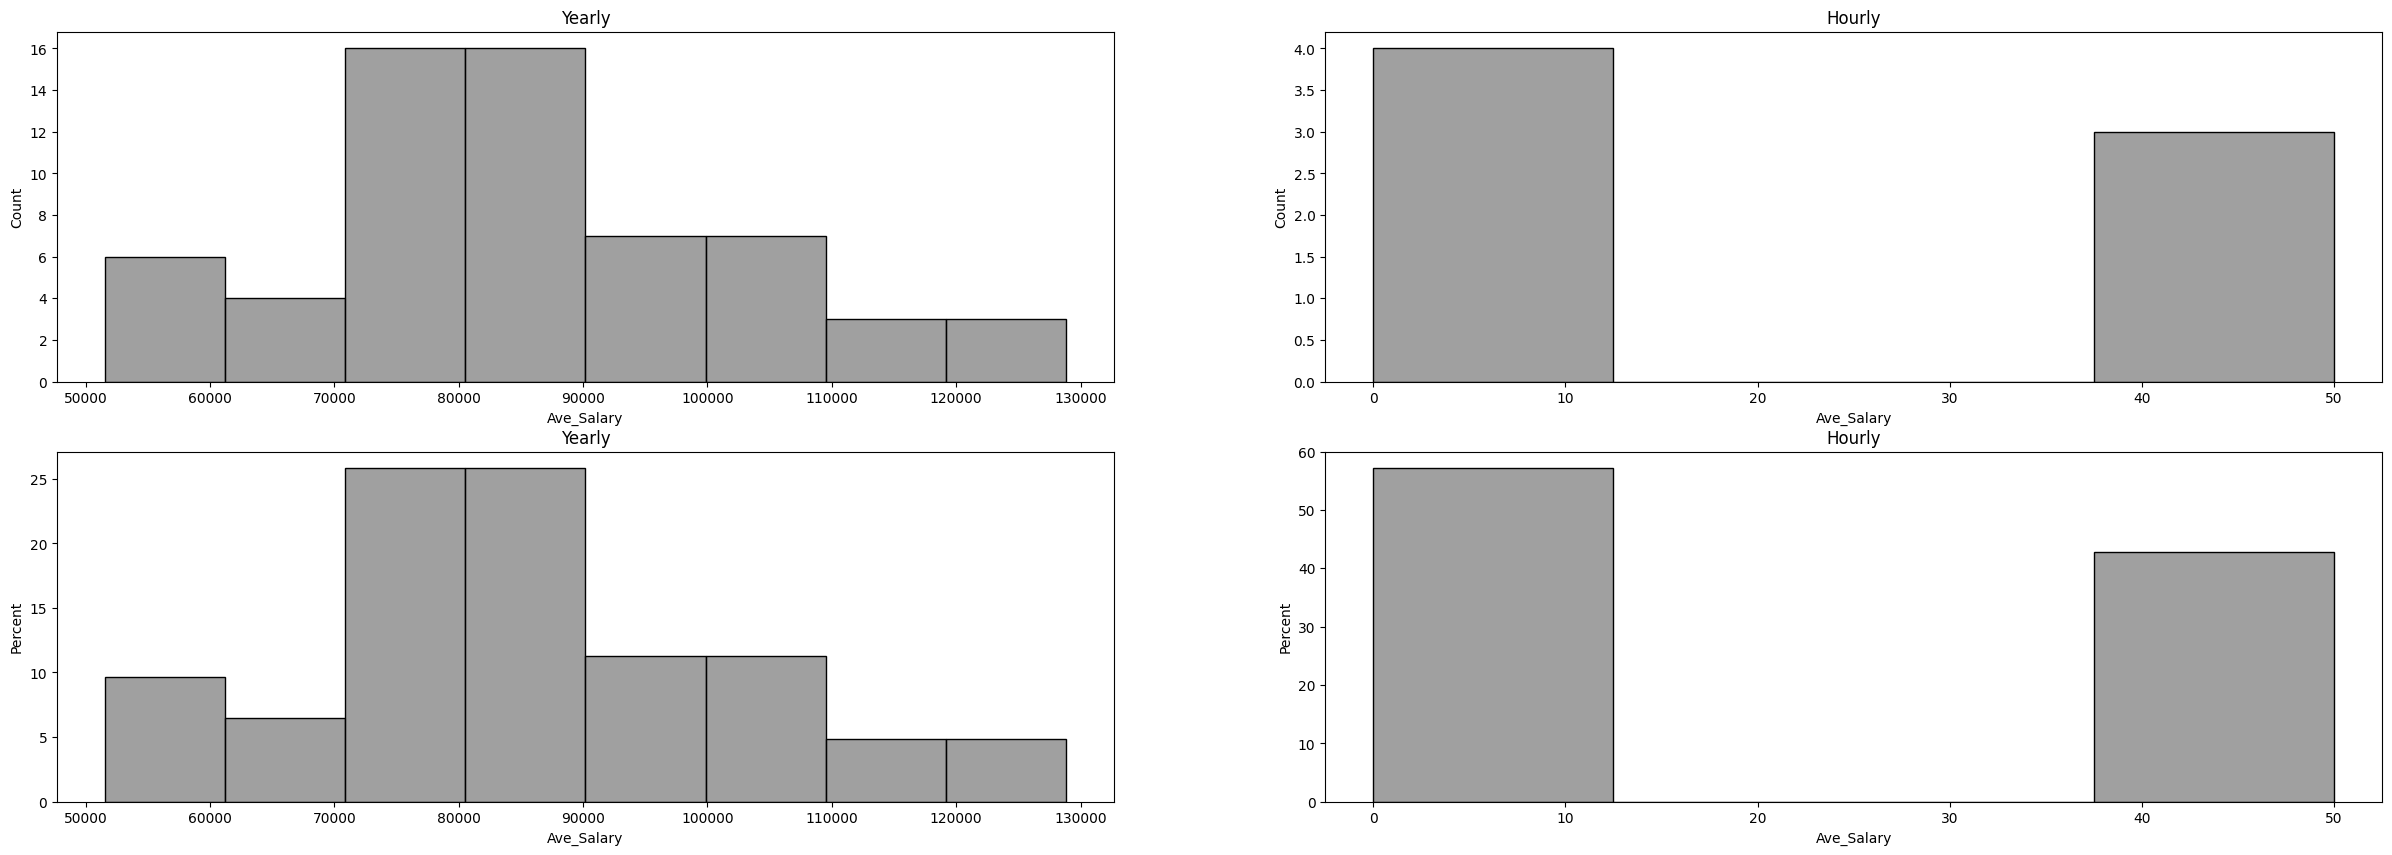

In [31]:
fig = plt.figure(figsize=(30,10))
for idx , col in enumerate([('Yearly','count'),('Hourly','count'),('Yearly','percent'),('Hourly','percent')]):
    ax = fig.add_subplot(2,2,idx+1)
    sns.histplot(df[df.Salary_payment == col[0]]['Ave_Salary'] , ax=ax ,color='gray',stat=col[1])
    ax.set_title(col[0])


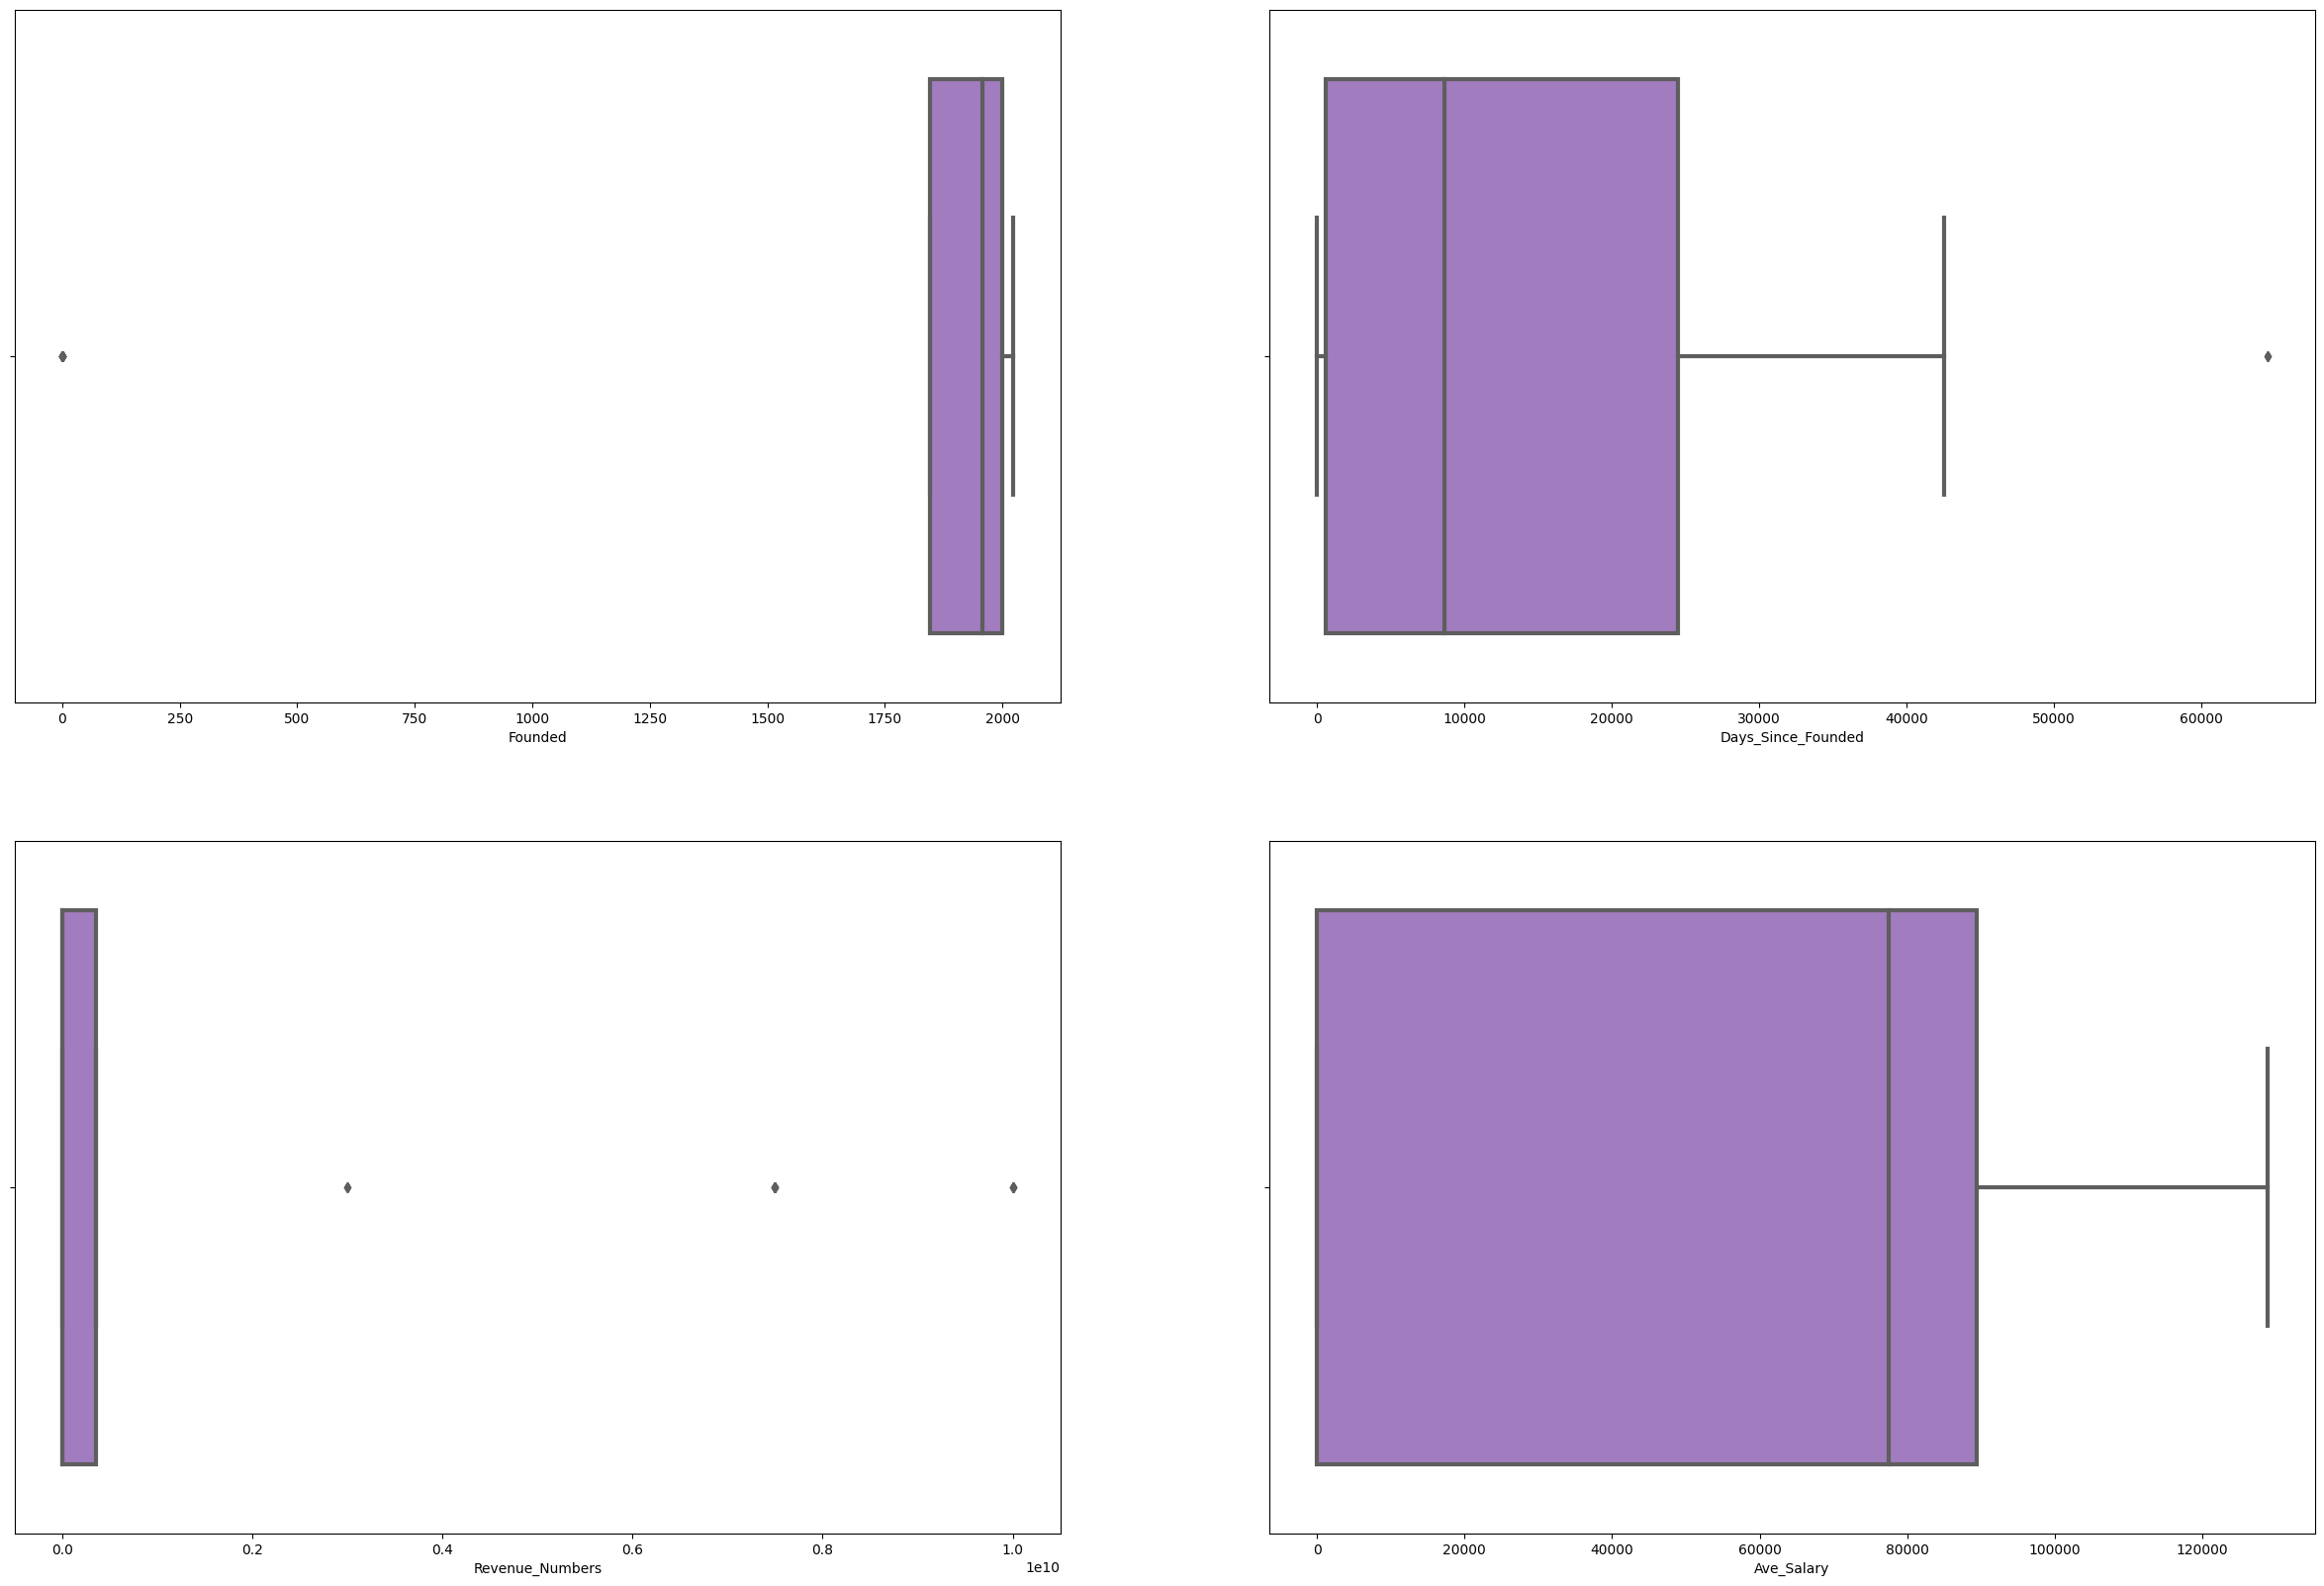

In [32]:
fig = plt.figure(figsize=(30,20))
for idx , col in enumerate(df.select_dtypes('number') , 1):
    ax = fig.add_subplot(2,2 , idx)
    sns.boxplot(x=df[col],linewidth=3,color='#a271c9')


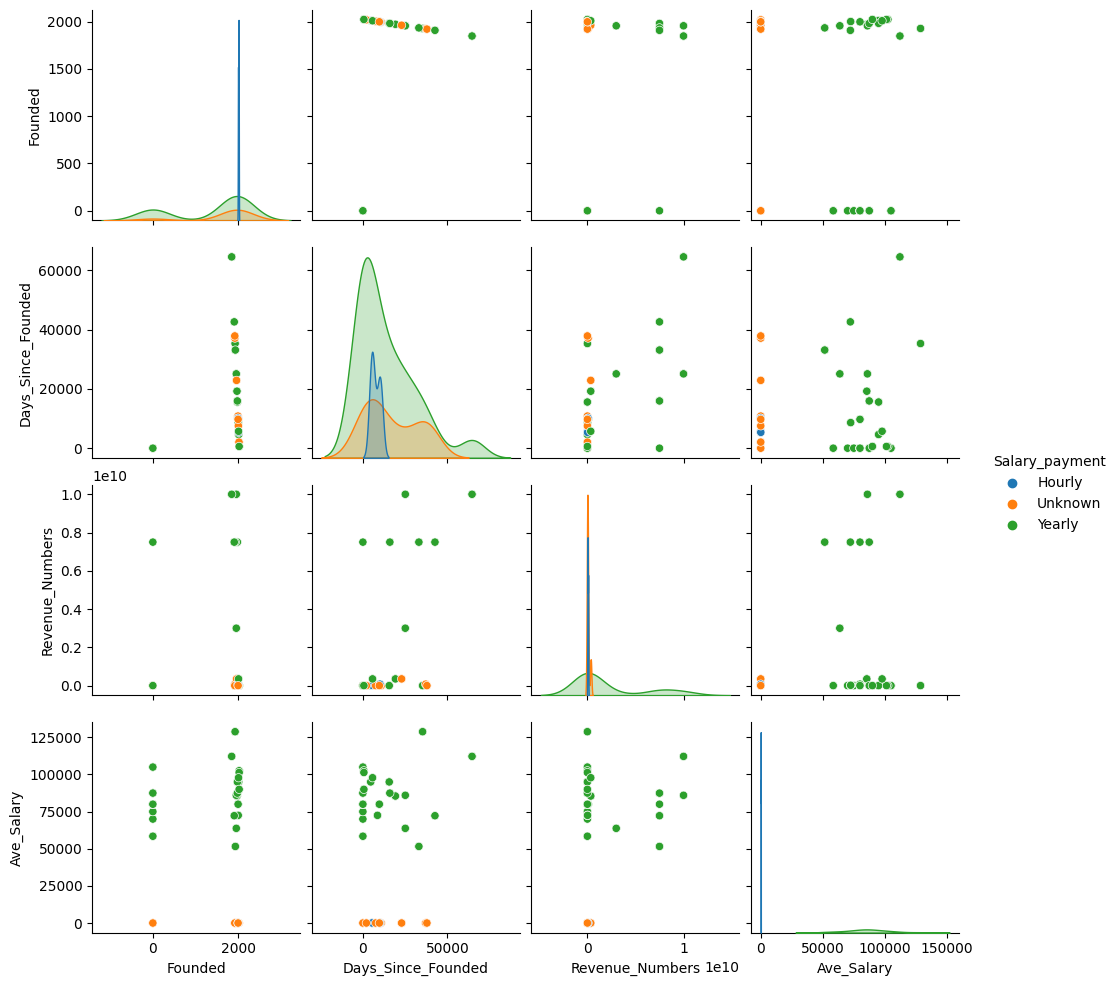

In [33]:
sns.pairplot(df , hue='Salary_payment')

C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\1325657536.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot=True , vmin=-1 , vmax=1 )


<AxesSubplot:>

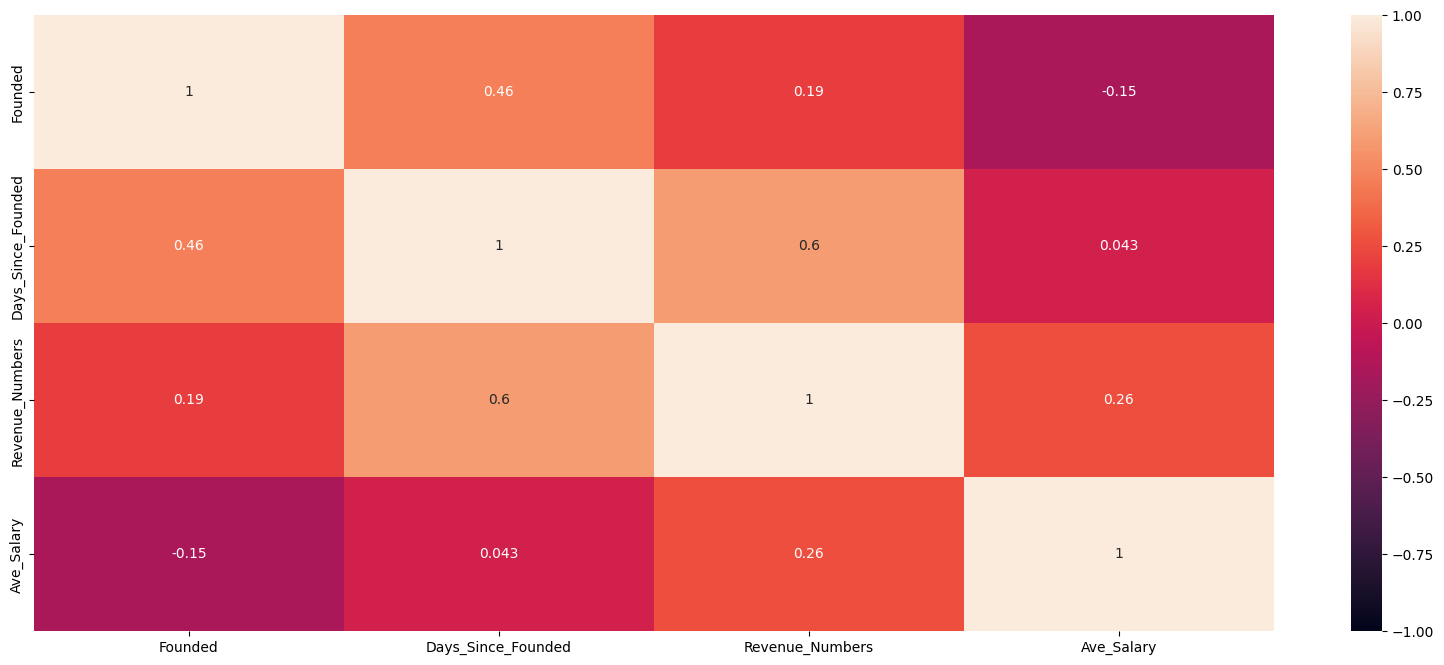

In [34]:
plt.figure(figsize=(20,8))
sns.heatmap(df.corr(),annot=True , vmin=-1 , vmax=1 )

<AxesSubplot:xlabel='Date_Posted', ylabel='Ave_Salary'>

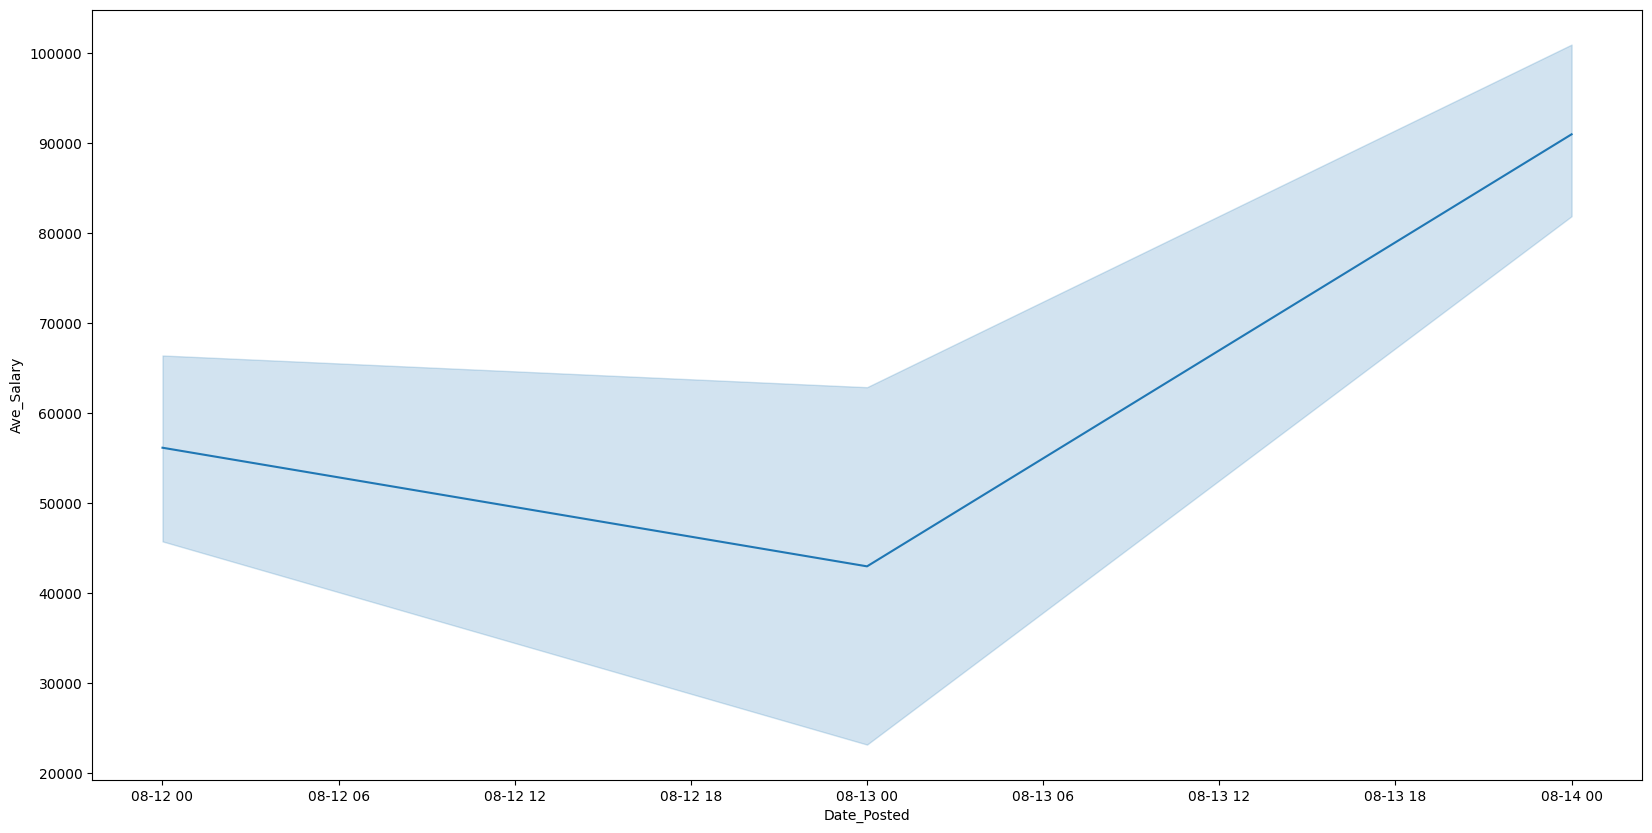

In [35]:
plt.figure(figsize=(20,10))
sns.lineplot(df , x='Date_Posted', y='Ave_Salary')

In [36]:
#Describe category data 
df.describe(exclude='number')

C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\1855496950.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(exclude='number')


,Job_Title,Company_Title,Location,Date_Posted,Size,Type,Industry,Sector,Revenue,Average_Salary,Estimate_Salary,Job_Description,State_name,Number_of_Employess,Salary_payment
count,90,90,90,90,90,90,90,90,90,90,90,90,90,90,90
unique,38,46,24,3,7,7,16,12,8,27,27,37,23,7,3
top,Business Analyst,Ascendion,Remote,2023-08-12 00:00:00,10000+ employees,private,unspecified,information technology,unknown / non-applicable,unknown,unknown,Our Organization:\n\nWelcome to Arkos Health! ...,Remote,10000,Yearly
freq,11,4,48,57,22,41,18,27,39,21,21,3,48,22,62
first,NaN,NaN,NaN,2023-08-12 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,2023-08-14 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


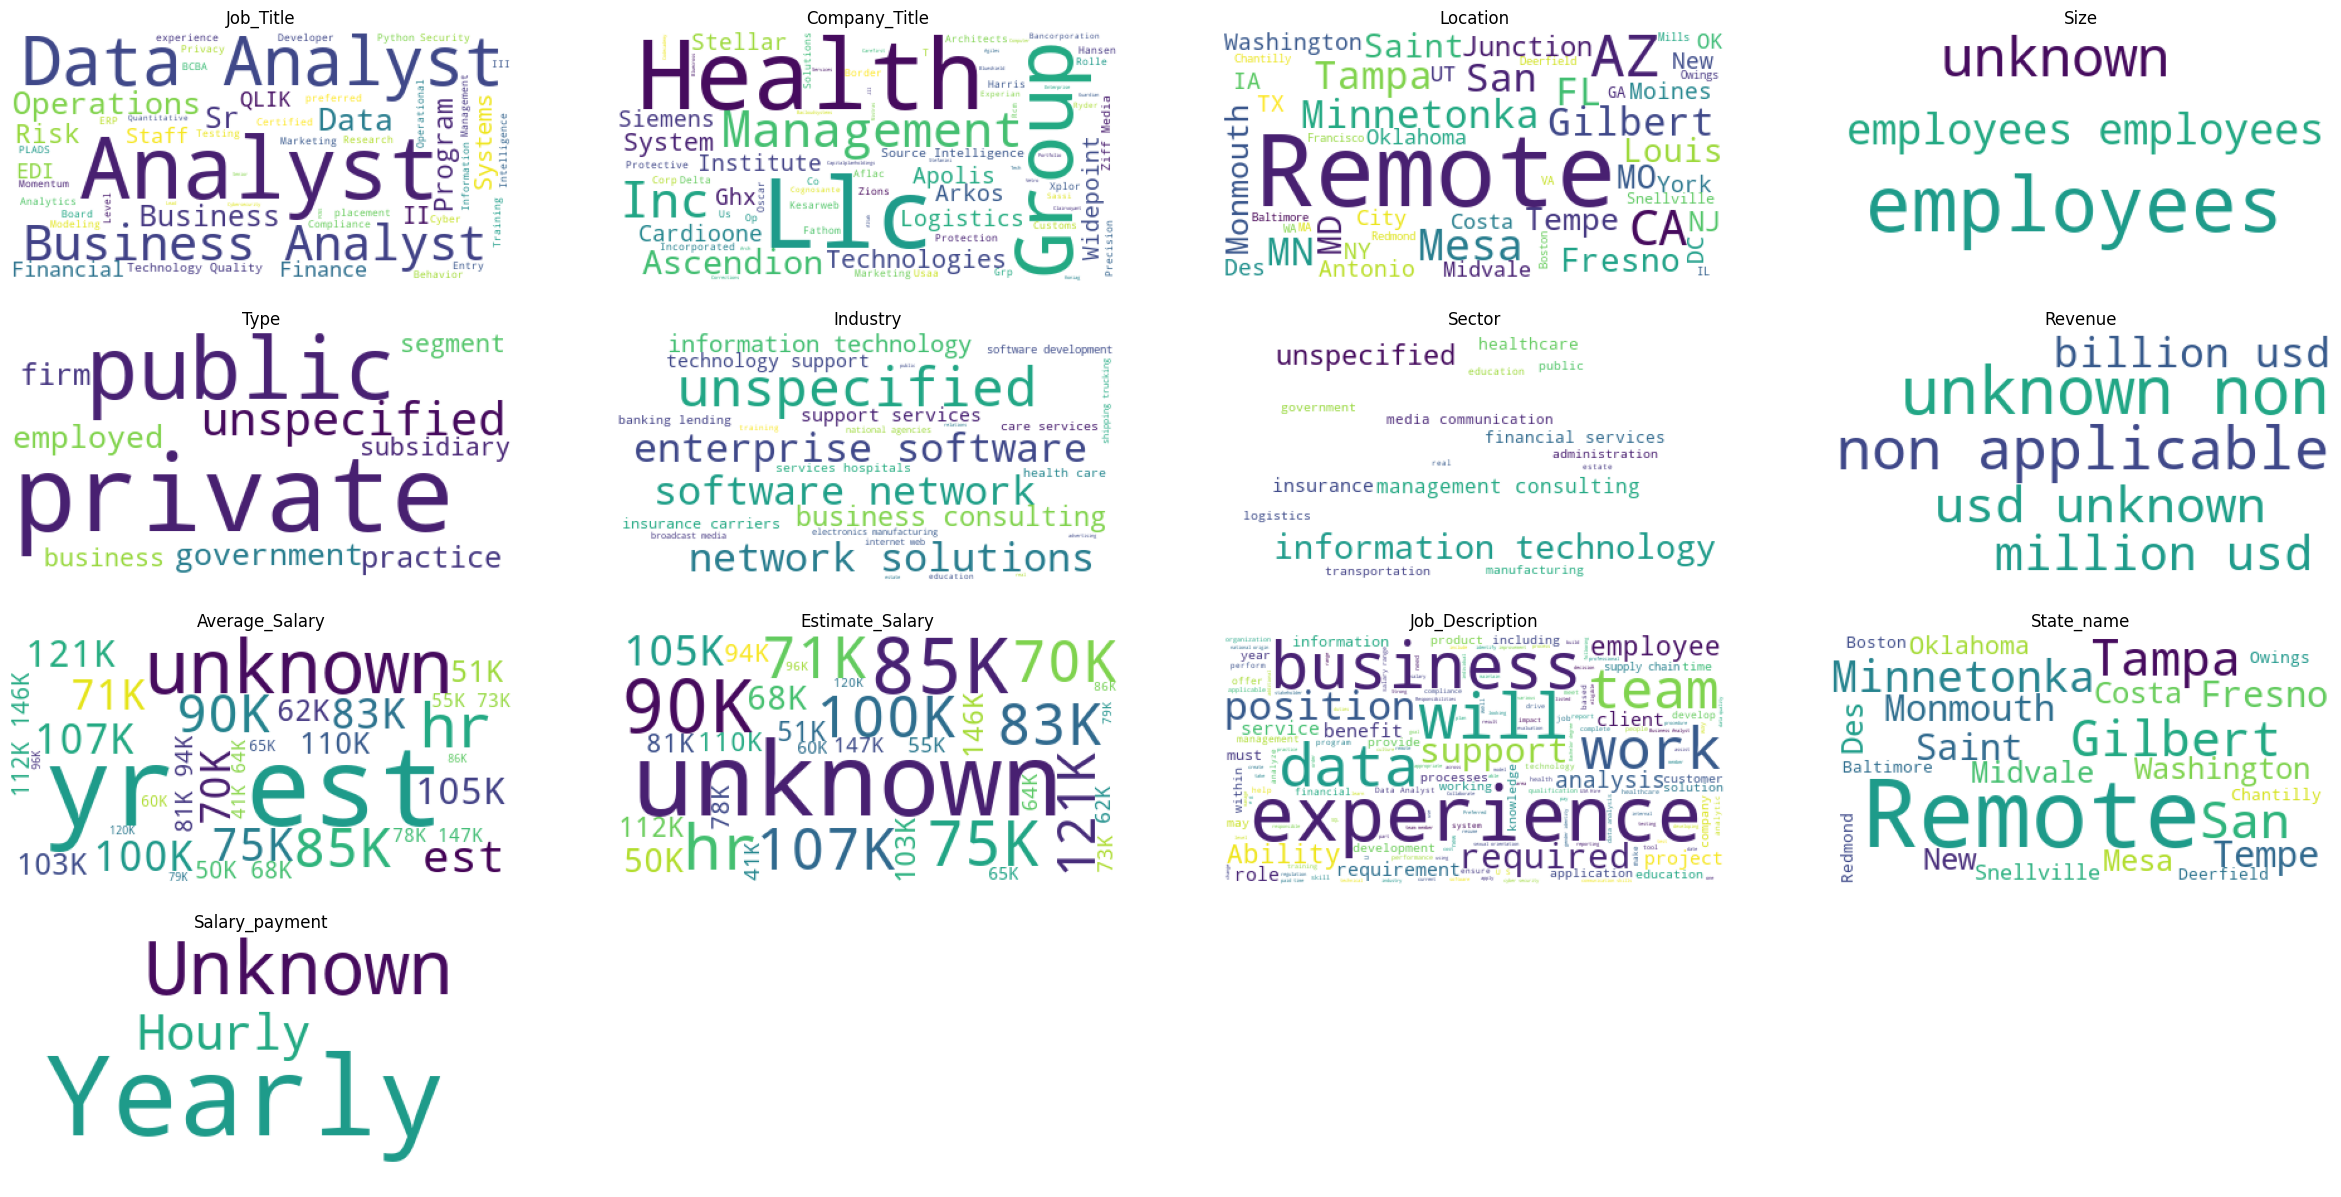

In [37]:
from wordcloud import WordCloud ,STOPWORDS
fig = plt.figure(figsize=(30,15))
for index , column in enumerate([col for col in df.select_dtypes(exclude='number').columns if 'Date_Posted' != col and 'Founded' != col and 'Number_of_Employess' != col]  , 1):
    ax = fig.add_subplot(4,4,index)
    words = WordCloud(
                    stopwords=set(STOPWORDS),
                    random_state=42,
                    background_color='white',
                    )\
                    .generate(' '.join(df[column].astype('str')))
    plt.imshow(words)
    plt.axis('off')
    ax.set_title(column)



C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\124406339.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,
C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\124406339.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,
C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\124406339.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,


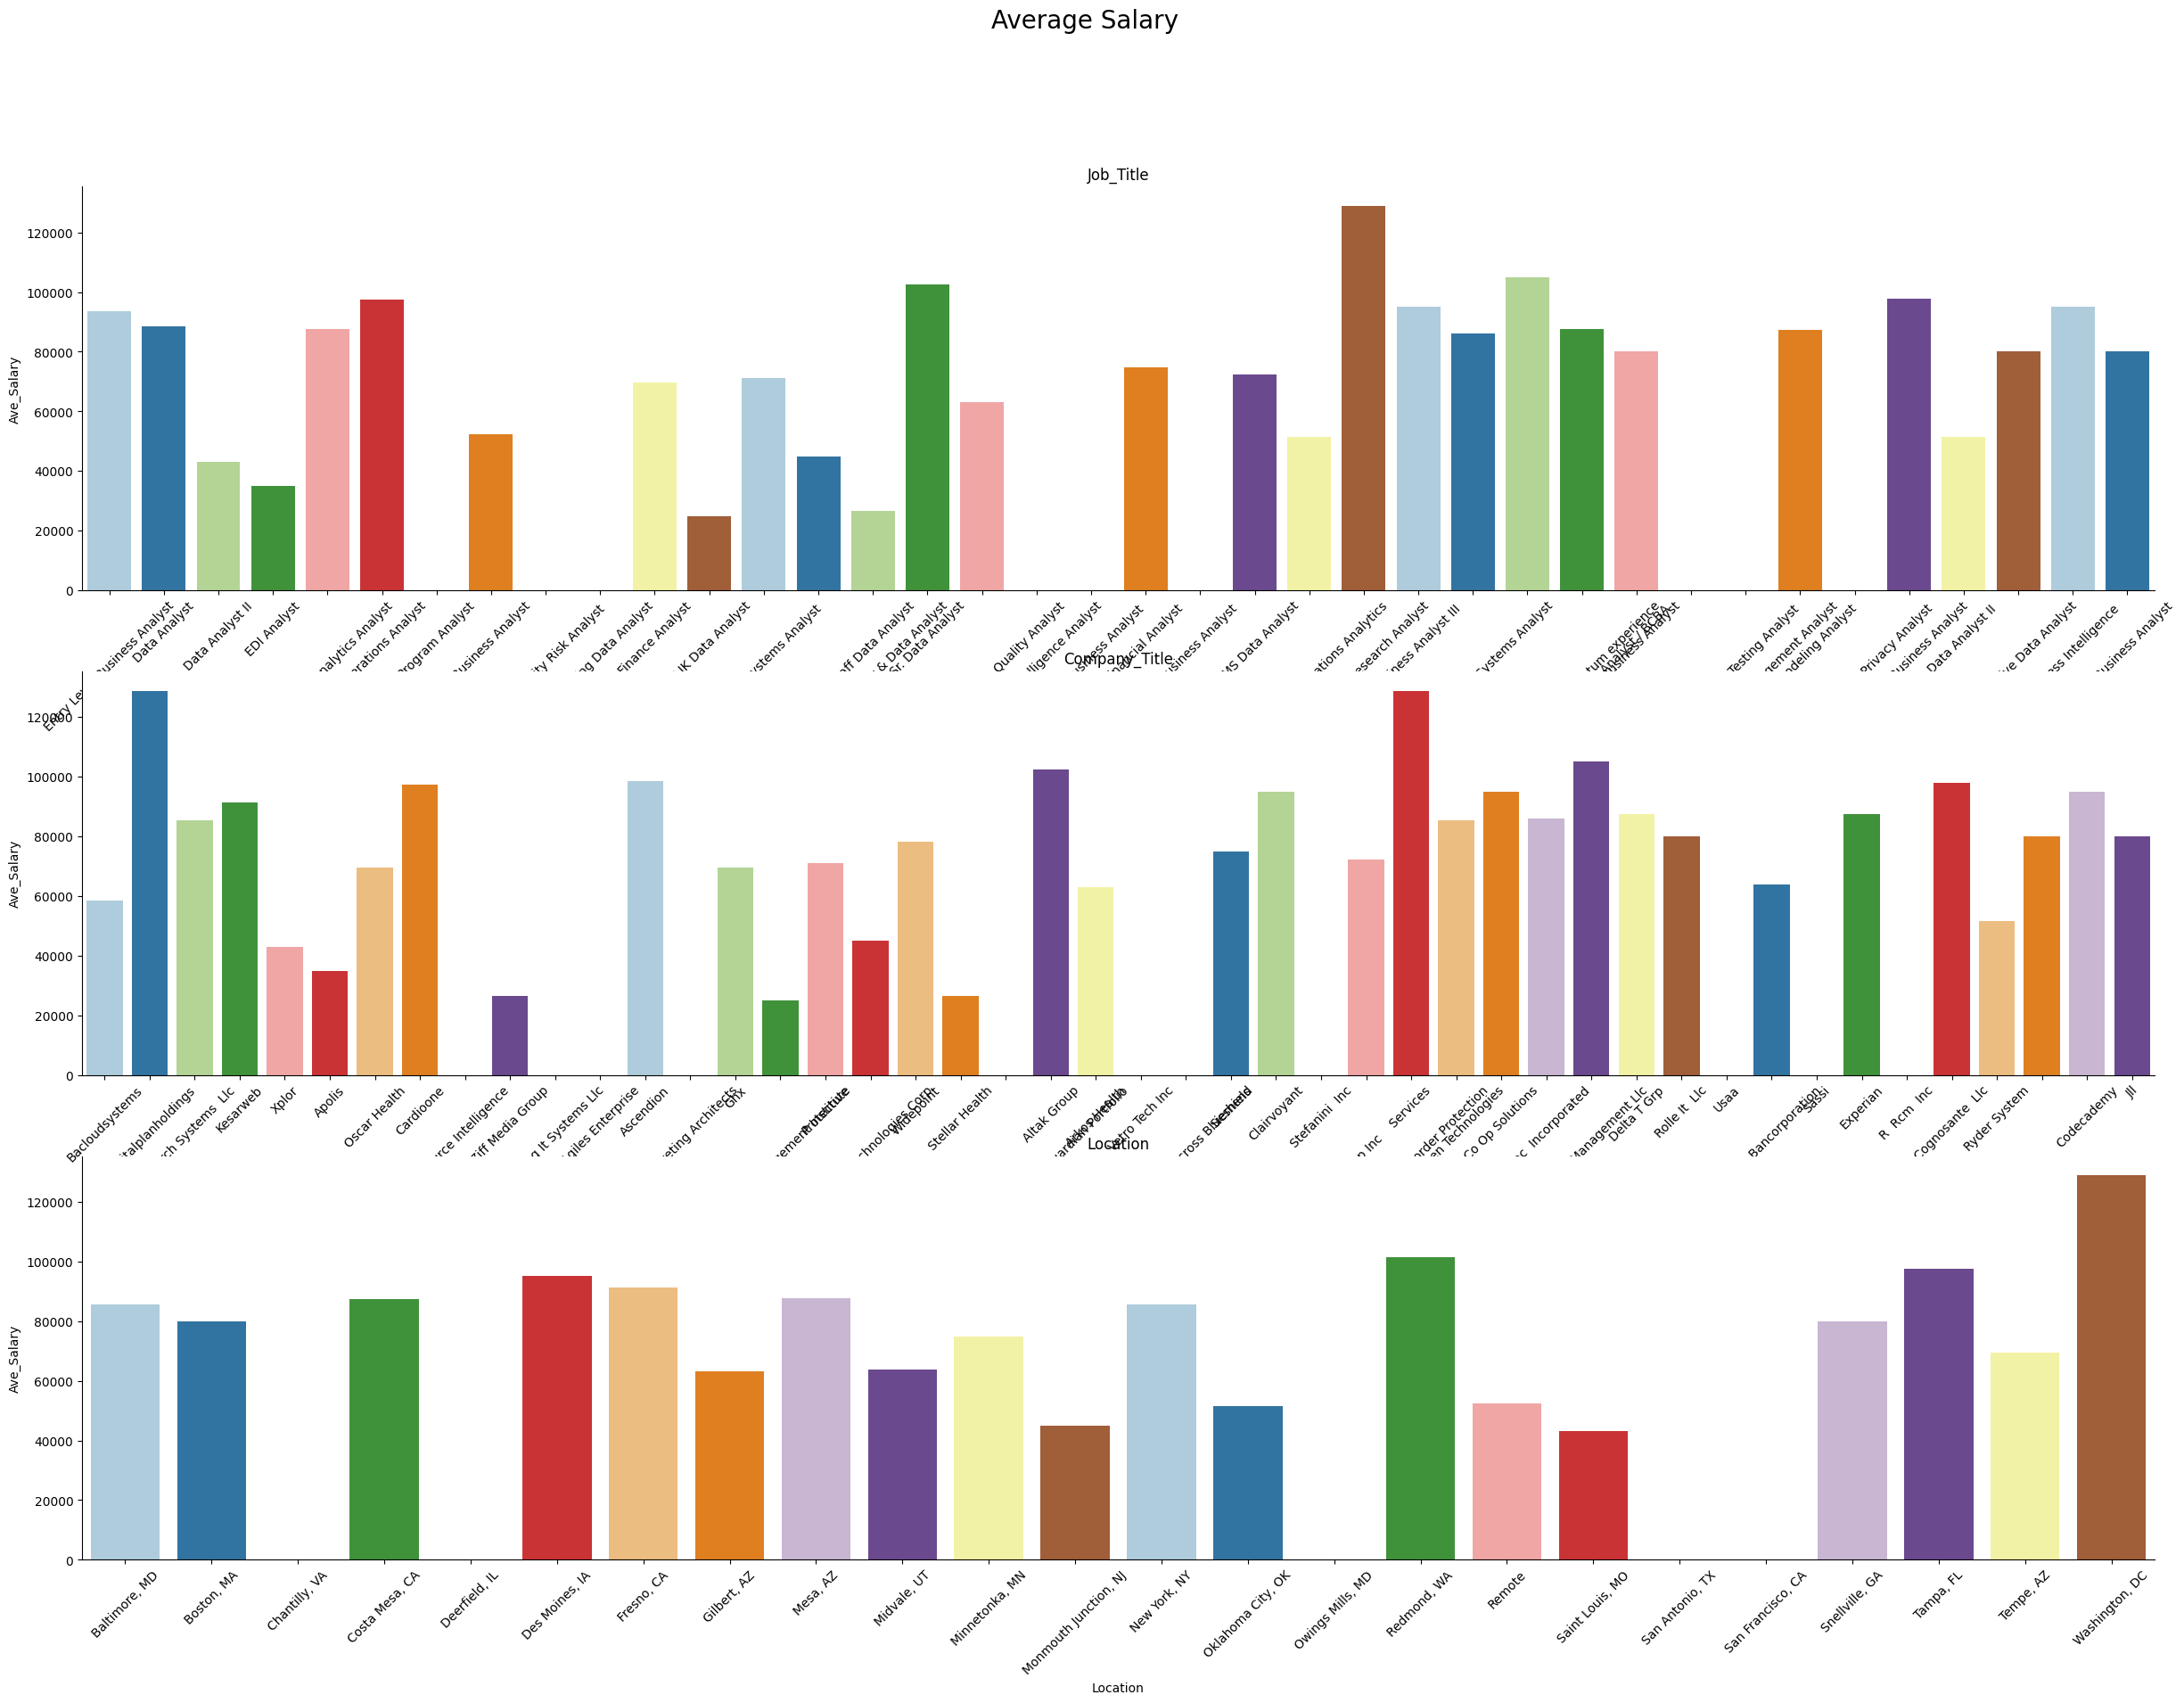

In [39]:
fig = plt.figure(figsize=(30,20))
for idx , col in enumerate(['Job_Title','Company_Title','Location']   , 1):
    ax = fig.add_subplot(3,1,idx)
    sns.barplot(data=df,
                x=df[col],
                y='Ave_Salary',
                estimator='mean',
                ci=None,
                palette='Paired')
    sns.despine()
    ax.set_title(col)
    plt.xticks(rotation=45 )
fig.suptitle('Average Salary',fontsize=20);    

C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\4156741973.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,
C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\4156741973.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,
C:\Users\bhr\AppData\Local\Temp\ipykernel_12436\4156741973.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df,


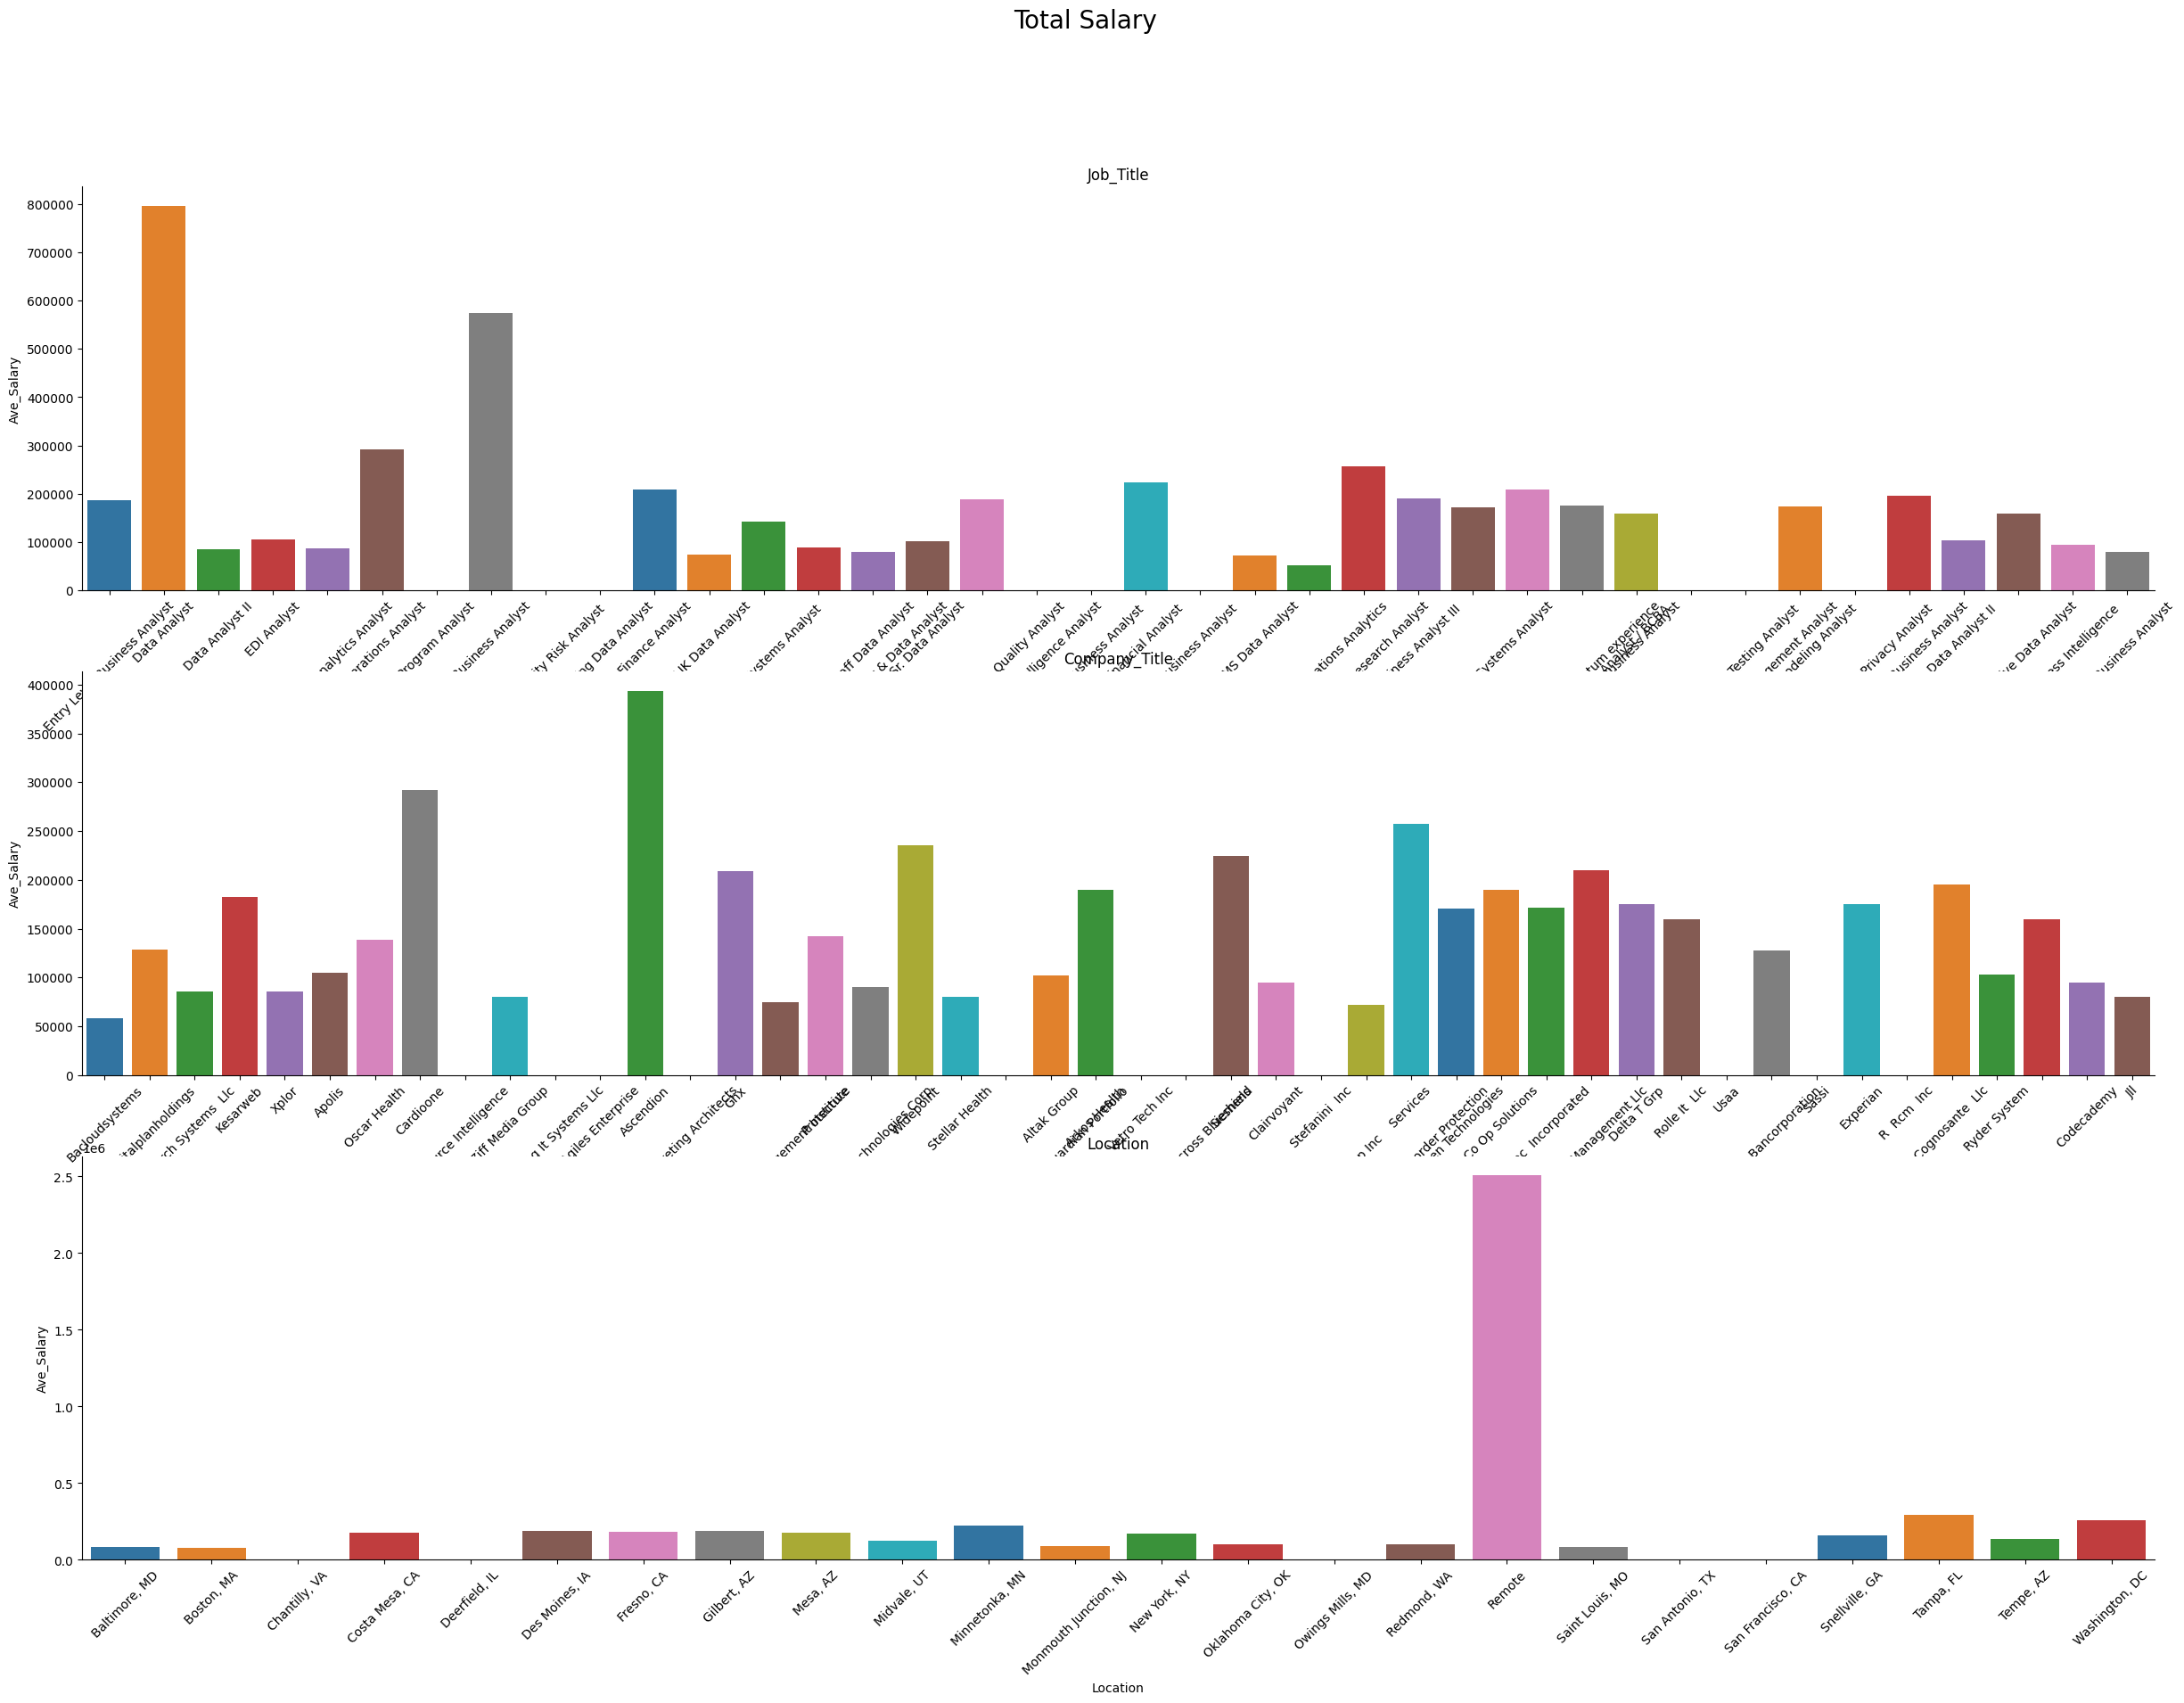

In [40]:
fig = plt.figure(figsize=(30,20))
for idx , col in enumerate(['Job_Title','Company_Title','Location']   , 1):
    ax = fig.add_subplot(3,1,idx)
    sns.barplot(data=df,
                x=df[col],
                y='Ave_Salary',
                estimator='sum',
                ci=None,
                palette='tab10')
    sns.despine()
    ax.set_title(col)
    plt.xticks(rotation=45 )
fig.suptitle('Total Salary',fontsize=20);   

---

- __Analyze__

In [ ]:
# Description for each category column
with open('H:/CS50/Portfolio Projects/Data Analyst Jobs/assets/reset.css','w') as file:
        file.write('body{background-color:#333333;}\n')
        file.close()
background_style = "/assets/reset.css"
app = JupyterDash(__name__ ,external_stylesheets=[background_style])
app.layout = html.Div([
                      html.H3(id='title' , style={'text-align':'center'}),
                      dmc.Grid(
                              justify='center',
                              gutter='xl',
                              children=[
                                        dmc.Col([
                                              dcc.Dropdown(
                                                            options=[{'label': col.replace("_"," ") if  "_" in col else col , 'value':col}for col in df.select_dtypes('category').columns],
                                                            # value='Job_Title',
                                                            placeholder = 'Select A Column',
                                                            id='dropdown',
                                                            optionHeight=50
                                                        ),
                                                      ],span=5)  ,
                                        dmc.Col([
                                                dcc.Dropdown(
                                                            options=(['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']),
                                                            # value='Job_Title',
                                                            placeholder = 'Select The Matrices',
                                                            id='dropdown2',
                                                            optionHeight=50,
                                                            multi=True
                                                        ),    
                                                     ],span=5) ,
                                        dmc.Col([dcc.Graph(id='Bar-Chart') ],span=12  )                   
                                            
                                            ]
                             )         
])
@app.callback(
              Output('title','children'),
              Output('Bar-Chart','figure'),
              Input('dropdown','value'),
              Input('dropdown2','value')
)
def bar(cateogry_column , Matrices):
    if not cateogry_column and Matrices:
        raise PreventUpdate
    data = df.groupby(cateogry_column)[['Ave_Salary']].describe().droplevel(0 ,axis=1).reset_index().round()
    title = f'Describe Average Salary by {cateogry_column.replace("_"," ") if "_" in cateogry_column else cateogry_column}'
    fig = px.bar(
                 data,
                 x=cateogry_column,
                 y=Matrices,
                 height=900,
                 labels={'value':'','variable':''},
                 color_discrete_sequence=px.colors.qualitative.G10)\
          .update_traces(marker =dict(line = {'width':2 , 'color':'white'}) )\
          .update_layout(xaxis = {'tickangle':-45 , 'showgrid':False ,'ticks':'outside' ,'tickwidth':5},
                         plot_bgcolor='#333333',
                         paper_bgcolor ='#333333',
                         font_color = 'white',
                         font_family = 'Arile',
                         legend={'orientation':'h' , 'x':0.7 , 'y':1.1})
    return title ,  fig
if __name__ == '__main__':
    app.run_server(mode='inline',debug = False)


 * Running on http://127.0.0.1:8050 (Press CTRL+C to quit)
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_alive_13cf0a85-9de5-4a80-b14a-93082ceb22af HTTP/1.1" 200 -


127.0.0.1 - - [14/Aug/2023 17:10:57] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /assets/reset.css?m=1692022256.8570292 HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /assets/reset.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:10:57] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:10:58] "POST /_dash-update-component HTTP/1.1" 500 -


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
File c:\Users\bhr\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\frame.py:8389, in DataFrame.groupby(
    self=                       Job_Title         Company...     0  
89       80000  

[90 rows x 19 columns],
    by=None,
    axis=0,
    level=None,
    as_index=True,
    sort=True,
    group_keys=<no_default>,
    squeeze=False,
    observed=False,
    dropna=True
)
   8386     squeeze = False
   8388 if level is None and by is None:
-> 8389     raise TypeError("You have to supply one of 'by' and 'level'")
   8390 axis = self._get_axis_number(axis)
   8392 return DataFrameGroupBy(
   8393     obj=self,
   8394     keys=by,
   (...)
   8402     dropna=dropna,
   8403 )

TypeError: You have to supply one of 'by' and 'level'



127.0.0.1 - - [14/Aug/2023 17:11:03] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:05] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:06] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:08] "POST /_dash-update-component HTTP/1.1" 200 -


In [43]:
#Final Dashboard
with open('H:/CS50/Portfolio Projects/Data Analyst Jobs/assets/reset.css','w') as file:
        file.write('body{background-color:#29293d;}\n')
        file.close()
background_style = "/assets/reset.css"
app = Dash(__name__ ,external_stylesheets=[background_style])
app.layout = dbc.Container(
                           style={'backgroundColor':'#29293d'},
                           fluid= True ,
                           children=[
                                     html.H1('Glassdoor Data Analyst📈 Jobs💼 Dashboard📊' , style = {'color':'white' , 'text-align':'center'}),
                                     html.Hr(),
                                     dmc.Grid([
                                                dmc.Col([
                                                         dmc.Select(
                                                                    label='Select a Category Column',
                                                                    data=[{'label': col.replace("_"," ") if  "_" in col else col , 'value':col}for col in df.select_dtypes(exclude='number').columns if col not in ['Date_Posted','Average_Salary','Estimate_Salary','Job_Description','Number_of_Employess']],
                                                                    value='Job_Title',
                                                                    id='select-category',
                                                                #     style={"width": 200},
                                                                    size='sm',
                                                                      ),
                                                        ],span=6),
                                                dmc.Col([
                                                        dmc.Space(h=24),
                                                         dmc.SegmentedControl(
                                                                #      data=['Top 10' ,'Less 10'],
                                                                     data=[{'label':'Top 10','value':False},
                                                                           {'label':'Less 10' , 'value':True}],
                                                                     value=False,
                                                                     id='top_or_less',
                                                                     size='sm',
                                                                     fullWidth=True,
                                                                     color='dark'
                                                                                )
                                                         ],span=6)  ,
                                                dmc.Col([
                                                        dcc.Graph(id='bar_chart'),
                                                        ],span=6) ,
                                                dmc.Col([
                                                        html.Div(id='table'),
                                                        dcc.Graph(id='bar_palor')
                                                        ],span=6),
                                               ])
                                    ]
)
@app.callback(
              Output('bar_chart','figure'),
              Output('table','children'),
              Output('bar_palor','figure'),
              Input('select-category','value'),
              Input('top_or_less','value'),
)
def plot(category , top_less):
        data = df.groupby(category,as_index=False).agg({'Ave_Salary':'sum'})
        data_table = data.sort_values(by=category , ascending = top_less).head(10)
        bar_chart = px.bar(
                data,
                x=category,
                y='Ave_Salary',
                height=850,
                color_discrete_sequence=['#666699'],
                text='Ave_Salary',
                labels={category:''},
                title = f'<b>Average Salary By {category.replace("_"," ") if "_" in category else category}</b>')\
                .update_traces(texttemplate = '%{text:.2s}',textposition = 'outside',marker =dict(line = {'width':0.5 , 'color':'white'}))\
                .update_layout(
                          xaxis = {'tickangle':-45 , 'showgrid':False ,'ticks':'outside' ,'tickwidth':2,'tickcolor':'white'},
                          yaxis = {'showgrid':False , 'visible':False},
                          plot_bgcolor='#29293d',
                          paper_bgcolor ='#29293d',
                          font_color = 'White',
                          font_family='Arile',
                          title_x = 0.5,
                          )

        table = dash_table.DataTable(data = data_table.to_dict('records'),
                                     columns=[{"name": i, "id": i} for i in data_table.columns],
                                     sort_action='native',
                                     style_header=dict(backgroundColor="#666699" , textAlign = 'left' , color='white'),
                                     style_data=dict(backgroundColor="#b3b3cc",textAlign = 'left', color='white')) 

        bar_palor= px.bar_polar(data_table, 
                                r="Ave_Salary", 
                                theta=category,
                                color_discrete_sequence=['#666699'])\
                   .update_layout(
                                plot_bgcolor='#29293d',
                                paper_bgcolor ='#29293d',
                                font_color = 'White',
                                font_family='Arile',
                                polar=dict(radialaxis = dict( showticklabels=False, ticks=''))    
                                )                        


        return bar_chart , table , bar_palor

if __name__ == '__main__':
    app.run_server(port=4444,debug = False)

 * Running on http://127.0.0.1:4444 (Press CTRL+C to quit)
127.0.0.1 - - [14/Aug/2023 17:11:28] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /assets/reset.css?m=1692022285.4823449 HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /assets/reset.css HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:11:29] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [14/Aug/2023 17:11:30] "GET /_dash-component-suites/dash/dash_table/async-highlight.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:11:30] "GET /_dash-component-suites/dash/dash_table/async-table.js HTTP/1.1" 304 -
127.0.0.1 - - [14/Aug/2023 17:

In [44]:
#Save the data in CSV file
df.to_csv('remote-data-analyst-jobs.csv')